In [16]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from datetime import datetime
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [17]:
# # use for google Colab

# from google.colab import drive
# drive.mount('/content/drive')


In [18]:
# use for google Colab
# !ls /content/drive/MyDrive/Regex_CNN_Project/dataset # check the folder TRAIN and TEST show using ls / dir  

In [19]:
# use for google Colab
# !cd /content/drive/MyDrive/Regex_CNN_Project

In [20]:
# data_dir = '/content/drive/MyDrive/Regex_CNN_Project/dataset/' # use for google Colab
data_dir = './dataset/'
train_dir = data_dir + 'TRAIN'
test_dir = data_dir + 'TEST'
# parameters
img_width, img_height = 224, 224  # dimensions to which the images will be resized
batch_size = 32
num_epochs = 32
num_classes = 6  #categories of trash

In [21]:
from keras_preprocessing.image import ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1.0/255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True,rotation_range=30, validation_split=0.2,
width_shift_range=0.2, height_shift_range=0.2)
test_data_gen = ImageDataGenerator(rescale=1.0/255)

In [22]:
train_data = train_data_gen.flow_from_directory(train_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode="categorical",subset='training')

valid_data = train_data_gen.flow_from_directory(train_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode="categorical",subset='validation')

test_data = test_data_gen.flow_from_directory(test_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode="categorical")


Found 1603 images belonging to 6 classes.
Found 398 images belonging to 6 classes.
Found 0 images belonging to 0 classes.


In [23]:
train_data.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [24]:
train_data.image_shape

(224, 224, 3)

In [25]:
def timer(start_time=None):
    if not start_time:
        print(datetime.now())
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [26]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model1 = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [28]:
for layer in model1.layers:
    layer.trainable = False

In [29]:
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(model1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
prediction1 = layers.Dense(6, activation='sigmoid')(x)

model1 = tf.keras.models.Model(inputs = model1.input, outputs=prediction1)

model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [30]:
model1.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
start_time=timer(None)
result1 = model1.fit(train_data, validation_data=valid_data, epochs = 32, steps_per_epoch = len(train_data))
timer(start_time)

2021-07-17 07:31:35.133949
Epoch 1/32
51/51 [==============================] - 148s 3s/step - loss: 3.2123 - accuracy: 0.5028 - val_loss: 1.6747 - val_accuracy: 0.5201
Epoch 2/32
51/51 [==============================] - 55s 1s/step - loss: 1.0376 - accuracy: 0.6575 - val_loss: 0.8671 - val_accuracy: 0.6834
Epoch 3/32
51/51 [==============================] - 92s 2s/step - loss: 0.9266 - accuracy: 0.6931 - val_loss: 0.9984 - val_accuracy: 0.6709
Epoch 4/32
51/51 [==============================] - 134s 3s/step - loss: 0.9360 - accuracy: 0.7168 - val_loss: 0.8850 - val_accuracy: 0.6658
Epoch 5/32
51/51 [==============================] - 128s 3s/step - loss: 0.8287 - accuracy: 0.7162 - val_loss: 0.7707 - val_accuracy: 0.7211
Epoch 6/32
51/51 [==============================] - 77s 1s/step - loss: 0.7505 - accuracy: 0.7480 - val_loss: 0.8084 - val_accuracy: 0.7412
Epoch 7/32
51/51 [==============================] - 362s 7s/step - loss: 0.7432 - accuracy: 0.7455 - val_loss: 0.8730 - val_accura

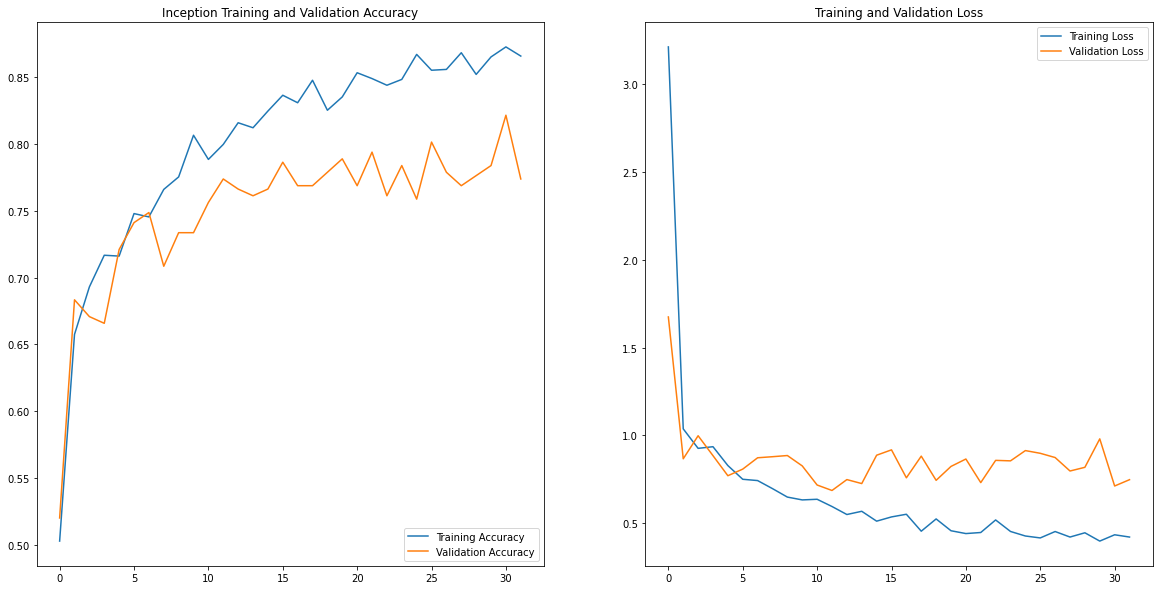

In [31]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Inception Training and Validation Accuracy")
plt.plot( result1.history["accuracy"], label='Training Accuracy')
plt.plot( result1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot( result1.history["loss"], label='Training Loss')
plt.plot( result1.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
model1.save('project_incept.h5')